# 🚀 NVIDIA H100 Single-GPU Training: EfficientNetB6 (V8 Auto-Validation)

**Hardware Target:** HPE ProLiant DL380 G11 (Using 1x H100 94GB)
**Fix V8:** 
1. **Auto Validation:** Removed `validation_steps` to allow dynamic end-of-epoch detection (Fixes 'Ran out of data' warning).
2. **Single GPU Mode:** Uses only GPU 0 for maximum stability.
**Path:** /workspace/AiTaxonomy

In [1]:
import os

# =============================================================================
# 🔧 CRITICAL SETUP (Run BEFORE importing TensorFlow)
# =============================================================================
# Force TensorFlow to see only ONE GPU (Card #0)
# Reason: This completely eliminates multi-GPU NCCL communication errors.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Use Async Allocator for better memory management on H100
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

print("✅ Configured for Single GPU Stability (NCCL bypassed).")

import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Single GPU Setup ---
tf.keras.backend.clear_session()

# Enable TensorFloat-32 (TF32) for H100 acceleration
tf.config.experimental.enable_tensor_float_32_execution(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        # Use OneDeviceStrategy (Simple & Robust)
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print(f"✅ Active GPU: {gpus[0].name}")
        print(f"✅ Strategy: OneDeviceStrategy (Running on 1 H100)")
    except RuntimeError as e:
        print(e)
        strategy = tf.distribute.get_strategy()
else:
    print("⚠️ Running on CPU")
    strategy = tf.distribute.get_strategy()

# Set Policy to Float32 (TF32 handles the speedup internally)
# This avoids 'dtype' mismatch errors in EfficientNet preprocessing.
try:
    keras.mixed_precision.set_global_policy('float32')
    print('ℹ️  Policy set to: float32')
except:
    pass

✅ Configured for Single GPU Stability (NCCL bypassed).


2025-12-03 13:39:54.429396: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 13:39:54.467474: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ Active GPU: /physical_device:GPU:0
✅ Strategy: OneDeviceStrategy (Running on 1 H100)
ℹ️  Policy set to: float32


2025-12-03 13:39:56.313137: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:238] Using CUDA malloc Async allocator for GPU: 0
2025-12-03 13:39:56.314172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 90683 MB memory:  -> device: 0, name: NVIDIA H100 NVL, pci bus id: 0000:26:00.0, compute capability: 9.0


In [2]:
# =============================================================================
# 📝 2. Config & Interactive ID Selection
# =============================================================================

# --- PATHS ---
DATA_DIR = r"/workspace/Archive/All-Species"
BASE_SAVE_PATH = r"/workspace/AiTaxonomy/TF-Training-Logs-B6"
TFRECORD_BASE_PATH = r"/workspace/AiTaxonomy/TFRecords_AllSpecies_B6"

os.makedirs(BASE_SAVE_PATH, exist_ok=True)

# --- SELECT RUN ID ---
if not os.path.exists(TFRECORD_BASE_PATH):
    raise FileNotFoundError(f"❌ Path not found: {TFRECORD_BASE_PATH}")

available_ids = sorted(os.listdir(TFRECORD_BASE_PATH))
if not available_ids:
    raise FileNotFoundError("❌ No TFRecords found! Please run Prepare script.")

print(f"📂 Available Run IDs ({len(available_ids)} found):")
for i, run_id in enumerate(available_ids[-10:]): # Show last 10 IDs
    print(f"   [{i+1}] {run_id}")

print(f"\n👉 Latest ID: {available_ids[-1]}")
user_input = input("Enter RUN ID to use (or press Enter for Latest): ").strip()

if user_input:
    if user_input in available_ids:
        RUN_TIMESTAMP = user_input
    else:
        print(f"⚠️ ID '{user_input}' not found! Using Latest.")
        RUN_TIMESTAMP = available_ids[-1]
else:
    RUN_TIMESTAMP = available_ids[-1]

print(f"\n✅ SELECTED RUN ID: {RUN_TIMESTAMP}")

# --- Verify Content ---
TRAIN_TFREC_DIR = os.path.join(TFRECORD_BASE_PATH, RUN_TIMESTAMP, 'train')
VAL_TFREC_DIR   = os.path.join(TFRECORD_BASE_PATH, RUN_TIMESTAMP, 'val')

train_files = glob.glob(os.path.join(TRAIN_TFREC_DIR, '*.tfrecord'))
if not train_files:
    raise ValueError(f"❌ ERROR: Selected ID '{RUN_TIMESTAMP}' has NO train files in {TRAIN_TFREC_DIR}")

print(f"   Found {len(train_files)} train shards. Good to go!")

# --- Hyperparameters ---
IMG_SIZE = (528, 528)
INPUT_SHAPE = (528, 528, 3)

# Batch Size Strategy: Single H100 (94GB VRAM)
# We can comfortably use a larger batch size on a single card.
BATCH_SIZE = 48  

EPOCHS = 40
FINE_TUNE_EPOCHS = 20
PHASE3_EPOCHS = 20

LEARNING_RATE_PHASE1 = 0.005
LEARNING_RATE_PHASE2 = 1e-4
LEARNING_RATE_PHASE3 = 1e-5

AUTOTUNE = tf.data.AUTOTUNE
print(f"✅ Config: EfficientNetB6 (528x528), Batch Size: {BATCH_SIZE}")

📂 Available Run IDs (2 found):
   [1] 20251202-115257
   [2] 20251203-065556

👉 Latest ID: 20251203-065556


Enter RUN ID to use (or press Enter for Latest):  20251203-065556



✅ SELECTED RUN ID: 20251203-065556
   Found 68 train shards. Good to go!
✅ Config: EfficientNetB6 (528x528), Batch Size: 48


In [3]:
# =============================================================================
# 📝 3. Data Pipeline
# =============================================================================

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=123),
    tf.keras.layers.RandomRotation(0.15, seed=123),
    tf.keras.layers.RandomContrast(0.15, seed=123),
    tf.keras.layers.RandomBrightness(0.15, seed=123)
])

def load_dataset(pattern, is_training=True):
    files = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    
    def _parse(example):
        feature_desc = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'label': tf.io.FixedLenFeature([], tf.int64)
        }
        ex = tf.io.parse_single_example(example, feature_desc)
        # Use decode_jpeg because we encoded as .jpg in prepare script
        img = tf.io.decode_jpeg(ex['image'], channels=3)
        img = tf.cast(img, tf.float32)
        img = tf.reshape(img, [IMG_SIZE[0], IMG_SIZE[1], 3])
        return img, ex['label']
    
    dataset = dataset.map(_parse, num_parallel_calls=AUTOTUNE)
    # Load dataset into RAM (Server has 1TB RAM)
    dataset = dataset.cache()

    if is_training:
        dataset = dataset.shuffle(10000)
        dataset = dataset.repeat()
        # Drop remainder ensures fixed shape, good for tensor compilation
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    else:
        # Drop remainder on validation too for consistency
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        
    return dataset.prefetch(AUTOTUNE)

train_ds = load_dataset(os.path.join(TRAIN_TFREC_DIR, '*.tfrecord'), True)
val_ds   = load_dataset(os.path.join(VAL_TFREC_DIR,   '*.tfrecord'), False)

# Calculate Steps
n_train = len(glob.glob(os.path.join(TRAIN_TFREC_DIR, '*.tfrecord'))) * 2000 
n_val = len(glob.glob(os.path.join(VAL_TFREC_DIR, '*.tfrecord'))) * 2000
STEPS_PER_EPOCH = n_train // BATCH_SIZE
# NOTE: We do not strictly need VALIDATION_STEPS anymore due to auto-detection fix
print(f"Estimated Training Steps: {STEPS_PER_EPOCH}")

Estimated Training Steps: 2833


In [4]:
# =============================================================================
# 📝 4. Model (EfficientNetB6)
# =============================================================================

class_names = sorted(os.listdir(DATA_DIR)) if os.path.exists(DATA_DIR) else []
NUM_CLASSES = len(class_names)
print(f"Classes: {NUM_CLASSES}")

with strategy.scope():
    def build_model():
        inputs = layers.Input(shape=INPUT_SHAPE)
        base_model = tf.keras.applications.EfficientNetB6(
            include_top=False, 
            weights='imagenet', 
            input_tensor=inputs
        )
        base_model.trainable = False 

        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(NUM_CLASSES, activation='linear')(x)
        return keras.Model(inputs, outputs)

    model = build_model()
    
print(f"✅ Model Built for {NUM_CLASSES} classes on 1 GPU.")

Classes: 544
✅ Model Built for 544 classes on 1 GPU.


In [5]:
# =============================================================================
# 📝 5. Phase 1: Feature Extraction
# =============================================================================

ckpt_p1 = os.path.join(BASE_SAVE_PATH, f"B6_{RUN_TIMESTAMP}_P1.weights.h5")
callbacks = [
    # EarlyStopping monitors val_loss. 
    # Now that we fixed validation_steps, val_loss will be correctly calculated.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(ckpt_p1, save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)
]

with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_PHASE1),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['sparse_categorical_accuracy']
    )

print("🚀 START PHASE 1 (Freezing Backbone)...")
h1 = model.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH, 
    # REMOVED: validation_steps=VALIDATION_STEPS 
    # Explanation: Removing this allows Keras to automatically detect the end of the validation dataset,
    # preventing "Ran out of data" warnings due to drop_remainder.
    callbacks=callbacks
)

🚀 START PHASE 1 (Freezing Backbone)...
Epoch 1/40


2025-12-03 13:40:52.338518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90500
I0000 00:00:1764769253.529148    6857 service.cc:145] XLA service 0x78531e6635e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764769253.529197    6857 service.cc:153]   StreamExecutor device (0): NVIDIA H100 NVL, Compute Capability 9.0
2025-12-03 13:40:53.547893: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764769253.679780    6857 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2833/2833 [==============================] - ETA: 0s - loss: 3.6710 - sparse_categorical_accuracy: 0.3187

2025-12-03 13:53:54.386611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 13:53:54.386799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-12-03 13:53:54.596624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: val_loss improved from inf to 2.99983, saving model to /workspace/AiTaxonomy/TF-Training-Logs-B6/B6_20251203-065556_P1.weights.h5
2833/2833 [==============================] - 822s 276ms/step - loss: 3.6710 - sparse_categorical_accuracy: 0.3187 - val_loss: 2.9998 - val_sparse_categorical_accuracy: 0.4257
Epoch 2/40
2833/2833 [==============================] - ETA: 0s - loss: 3.3140 - sparse_categorical_accuracy: 0.3732

2025-12-03 14:06:34.435482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 14:06:34.435682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 2: val_loss improved from 2.99983 to 2.82862, saving model to /workspace/AiTaxonomy/TF-Training-Logs-B6/B6_20251203-065556_P1.weights.h5
2833/2833 [==============================] - 759s 268ms/step - loss: 3.3140 - sparse_categorical_accuracy: 0.3732 - val_loss: 2.8286 - val_sparse_categorical_accuracy: 0.4576
Epoch 3/40
2833/2833 [==============================] - ETA: 0s - loss: 3.2710 - sparse_categorical_accuracy: 0.3865

2025-12-03 14:19:13.786040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 14:19:13.786216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 3: val_loss did not improve from 2.82862
2833/2833 [==============================] - 758s 268ms/step - loss: 3.2710 - sparse_categorical_accuracy: 0.3865 - val_loss: 2.8609 - val_sparse_categorical_accuracy: 0.4484
Epoch 4/40
2833/2833 [==============================] - ETA: 0s - loss: 3.2443 - sparse_categorical_accuracy: 0.3957

2025-12-03 14:31:52.028769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 14:31:52.028954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 4: val_loss improved from 2.82862 to 2.77030, saving model to /workspace/AiTaxonomy/TF-Training-Logs-B6/B6_20251203-065556_P1.weights.h5
2833/2833 [==============================] - 760s 268ms/step - loss: 3.2443 - sparse_categorical_accuracy: 0.3957 - val_loss: 2.7703 - val_sparse_categorical_accuracy: 0.4830
Epoch 5/40
2833/2833 [==============================] - ETA: 0s - loss: 3.2457 - sparse_categorical_accuracy: 0.4007

2025-12-03 14:44:32.257184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 14:44:32.257372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 5: val_loss improved from 2.77030 to 2.70801, saving model to /workspace/AiTaxonomy/TF-Training-Logs-B6/B6_20251203-065556_P1.weights.h5
2833/2833 [==============================] - 760s 268ms/step - loss: 3.2457 - sparse_categorical_accuracy: 0.4007 - val_loss: 2.7080 - val_sparse_categorical_accuracy: 0.4855
Epoch 6/40
2833/2833 [==============================] - ETA: 0s - loss: 3.2592 - sparse_categorical_accuracy: 0.4037

2025-12-03 14:57:12.580096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 14:57:12.580261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 6: val_loss did not improve from 2.70801
2833/2833 [==============================] - 759s 268ms/step - loss: 3.2592 - sparse_categorical_accuracy: 0.4037 - val_loss: 2.8007 - val_sparse_categorical_accuracy: 0.4857
Epoch 7/40
2833/2833 [==============================] - ETA: 0s - loss: 3.2652 - sparse_categorical_accuracy: 0.4056

2025-12-03 15:09:50.909403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 15:09:50.909482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 7: val_loss did not improve from 2.70801
2833/2833 [==============================] - 758s 268ms/step - loss: 3.2652 - sparse_categorical_accuracy: 0.4056 - val_loss: 2.7523 - val_sparse_categorical_accuracy: 0.4927
Epoch 8/40
2833/2833 [==============================] - ETA: 0s - loss: 3.2656 - sparse_categorical_accuracy: 0.4066

2025-12-03 15:22:30.164825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 15:22:30.165010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 8: val_loss did not improve from 2.70801
2833/2833 [==============================] - 759s 268ms/step - loss: 3.2656 - sparse_categorical_accuracy: 0.4066 - val_loss: 2.7608 - val_sparse_categorical_accuracy: 0.4951
Epoch 9/40
2833/2833 [==============================] - ETA: 0s - loss: 3.2766 - sparse_categorical_accuracy: 0.4096

2025-12-03 15:35:09.002306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 15:35:09.002504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 9: val_loss did not improve from 2.70801
2833/2833 [==============================] - 759s 268ms/step - loss: 3.2766 - sparse_categorical_accuracy: 0.4096 - val_loss: 2.7259 - val_sparse_categorical_accuracy: 0.5032
Epoch 10/40
2833/2833 [==============================] - ETA: 0s - loss: 3.2897 - sparse_categorical_accuracy: 0.4095

2025-12-03 15:47:47.310583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 15:47:47.310784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 10: val_loss did not improve from 2.70801
2833/2833 [==============================] - 758s 268ms/step - loss: 3.2897 - sparse_categorical_accuracy: 0.4095 - val_loss: 2.7574 - val_sparse_categorical_accuracy: 0.4995
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


In [7]:
# =============================================================================
# 📝 6. Phase 2: Unfreeze & Fine-Tune (Flat Model Fix)
# =============================================================================

ckpt_p2 = os.path.join(BASE_SAVE_PATH, f"B6_{RUN_TIMESTAMP}_P2.weights.h5")
callbacks_p2 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(ckpt_p2, save_best_only=True, save_weights_only=True, monitor='val_loss')
]

# จำนวน Layer ท้ายสุดที่จะเปิดให้ Train (EfficientNetB6 มีประมาณ 600+ ชั้น)
# เปิด 100 ชั้นท้ายถือว่ากำลังดีสำหรับการ Fine-Tune
UNFREEZE_COUNT = 100 

print(f"🔓 Unfreezing top {UNFREEZE_COUNT} layers...")

# 1. Freeze ทั้งหมดก่อนเพื่อความชัวร์
for layer in model.layers:
    layer.trainable = False

# 2. เปิด Train เฉพาะ N ชั้นสุดท้าย (และเว้น BatchNorm ไว้)
for layer in model.layers[-UNFREEZE_COUNT:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # BatchNorm ควร Freeze ไว้เสมอใน Fine-Tuning เพื่อรักษาสถิติ (Statistics) เดิม
        layer.trainable = False
    else:
        layer.trainable = True

# ตรวจสอบจำนวนตัวแปรที่ Train ได้
trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"✅ Trainable parameters: {trainable_count:,}")

with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_PHASE2),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['sparse_categorical_accuracy']
    )

print("🚀 START PHASE 2 (Fine-Tuning Top Layers)...")
h2 = model.fit(
    train_ds, 
    epochs=FINE_TUNE_EPOCHS, 
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH, 
    # REMOVED: validation_steps (Auto-detect)
    callbacks=callbacks_p2
)

🔓 Unfreezing top 100 layers...
✅ Trainable parameters: 21,254,280
🚀 START PHASE 2 (Fine-Tuning Top Layers)...
Epoch 1/20


2025-12-03 15:53:11.137469: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2833/2833 [==============================] - ETA: 0s - loss: 1.5599 - sparse_categorical_accuracy: 0.6366

2025-12-03 16:07:54.889173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 16:07:54.889322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-12-03 16:07:55.097011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2833/2833 [==============================] - 915s 311ms/step - loss: 1.5599 - sparse_categorical_accuracy: 0.6366 - val_loss: 1.2175 - val_sparse_categorical_accuracy: 0.7253
Epoch 2/20
2833/2833 [==============================] - ETA: 0s - loss: 1.0888 - sparse_categorical_accuracy: 0.7367

2025-12-03 16:22:25.284998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 16:22:25.285174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 870s 307ms/step - loss: 1.0888 - sparse_categorical_accuracy: 0.7367 - val_loss: 1.0362 - val_sparse_categorical_accuracy: 0.7664
Epoch 3/20
2833/2833 [==============================] - ETA: 0s - loss: 0.8683 - sparse_categorical_accuracy: 0.7850

2025-12-03 16:36:56.011022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 16:36:56.011169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 871s 307ms/step - loss: 0.8683 - sparse_categorical_accuracy: 0.7850 - val_loss: 0.9346 - val_sparse_categorical_accuracy: 0.7893
Epoch 4/20
2833/2833 [==============================] - ETA: 0s - loss: 0.7159 - sparse_categorical_accuracy: 0.8184

2025-12-03 16:51:27.911213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 16:51:27.911435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 872s 308ms/step - loss: 0.7159 - sparse_categorical_accuracy: 0.8184 - val_loss: 0.8673 - val_sparse_categorical_accuracy: 0.8023
Epoch 5/20
2833/2833 [==============================] - ETA: 0s - loss: 0.6013 - sparse_categorical_accuracy: 0.8433

2025-12-03 17:06:00.041307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 17:06:00.041495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 872s 308ms/step - loss: 0.6013 - sparse_categorical_accuracy: 0.8433 - val_loss: 0.8506 - val_sparse_categorical_accuracy: 0.8112
Epoch 6/20
2833/2833 [==============================] - ETA: 0s - loss: 0.5092 - sparse_categorical_accuracy: 0.8640

2025-12-03 17:20:30.811547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 17:20:30.811718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 871s 307ms/step - loss: 0.5092 - sparse_categorical_accuracy: 0.8640 - val_loss: 0.8221 - val_sparse_categorical_accuracy: 0.8220
Epoch 7/20
2833/2833 [==============================] - ETA: 0s - loss: 0.4366 - sparse_categorical_accuracy: 0.8823

2025-12-03 17:35:02.417309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 17:35:02.417489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 872s 308ms/step - loss: 0.4366 - sparse_categorical_accuracy: 0.8823 - val_loss: 0.8172 - val_sparse_categorical_accuracy: 0.8237
Epoch 8/20
2833/2833 [==============================] - ETA: 0s - loss: 0.3807 - sparse_categorical_accuracy: 0.8941

2025-12-03 17:49:35.537603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 17:49:35.537791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 872s 308ms/step - loss: 0.3807 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.8114 - val_sparse_categorical_accuracy: 0.8278
Epoch 9/20
2833/2833 [==============================] - ETA: 0s - loss: 0.3280 - sparse_categorical_accuracy: 0.9070

2025-12-03 18:04:06.974991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 18:04:06.975176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 871s 308ms/step - loss: 0.3280 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.8335
Epoch 10/20
2833/2833 [==============================] - ETA: 0s - loss: 0.2887 - sparse_categorical_accuracy: 0.9178

2025-12-03 18:18:39.309741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 18:18:39.309936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 871s 307ms/step - loss: 0.2887 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.8203 - val_sparse_categorical_accuracy: 0.8339
Epoch 11/20
2833/2833 [==============================] - ETA: 0s - loss: 0.2557 - sparse_categorical_accuracy: 0.9256

2025-12-03 18:33:10.758805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 18:33:10.759009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 871s 308ms/step - loss: 0.2557 - sparse_categorical_accuracy: 0.9256 - val_loss: 0.8164 - val_sparse_categorical_accuracy: 0.8348
Epoch 12/20
2833/2833 [==============================] - ETA: 0s - loss: 0.2282 - sparse_categorical_accuracy: 0.9342

2025-12-03 18:47:40.936323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 18:47:40.936494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 870s 307ms/step - loss: 0.2282 - sparse_categorical_accuracy: 0.9342 - val_loss: 0.8197 - val_sparse_categorical_accuracy: 0.8404
Epoch 13/20
2833/2833 [==============================] - ETA: 0s - loss: 0.2046 - sparse_categorical_accuracy: 0.9389

2025-12-03 19:02:10.392296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 19:02:10.392481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 869s 307ms/step - loss: 0.2046 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.8020 - val_sparse_categorical_accuracy: 0.8397
Epoch 14/20
2833/2833 [==============================] - ETA: 0s - loss: 0.1847 - sparse_categorical_accuracy: 0.9449

2025-12-03 19:16:40.098723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 19:16:40.098914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 870s 307ms/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9449 - val_loss: 0.8236 - val_sparse_categorical_accuracy: 0.8417
Epoch 15/20
2833/2833 [==============================] - ETA: 0s - loss: 0.1689 - sparse_categorical_accuracy: 0.9488

2025-12-03 19:31:09.287742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-03 19:31:09.287928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 869s 307ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.8403 - val_sparse_categorical_accuracy: 0.8411
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 9.


In [8]:
# =============================================================================
# 📝 7. Phase 3: Deep Fine-Tuning (Flat Model Fix)
# =============================================================================

ckpt_p3 = os.path.join(BASE_SAVE_PATH, f"B6_{RUN_TIMESTAMP}_P3.weights.h5")
callbacks_p3 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(ckpt_p3, save_best_only=True, save_weights_only=True, monitor='val_loss')
]

print("🔓 Unfreezing ALL layers for Deep Fine-Tuning...")

# วนลูปทุก Layer ใน Model หลักโดยตรง (แก้ปัญหาโครงสร้าง Flat)
for layer in model.layers:
    # ยังคงต้อง Freeze BatchNormalization ไว้เสมอ เพื่อความเสถียร
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        # Layer อื่นๆ (Conv2D, Dense, etc.) เปิดให้ Train ทั้งหมด
        layer.trainable = True

# เช็คจำนวน Parameter ที่จะ Train (ควรจะเยอะมาก หลักสิบล้าน)
trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"✅ Phase 3 Trainable parameters: {trainable_count:,}")

with strategy.scope():
    # Compile ใหม่ด้วย Learning Rate ที่ต่ำมาก (1e-5)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_PHASE3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['sparse_categorical_accuracy']
    )

print("🚀 START PHASE 3 (Full Unfreeze)... WARNING: Slow but Accurate")
h3 = model.fit(
    train_ds, 
    epochs=PHASE3_EPOCHS, 
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH, 
    # REMOVED: validation_steps (Auto-detect)
    callbacks=callbacks_p3
)

🔓 Unfreezing ALL layers for Deep Fine-Tuning...
✅ Phase 3 Trainable parameters: 41,765,192
🚀 START PHASE 3 (Full Unfreeze)... WARNING: Slow but Accurate
Epoch 1/20


2025-12-03 23:02:05.613165: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2833/2833 [==============================] - ETA: 0s - loss: 0.2027 - sparse_categorical_accuracy: 0.9413

2025-12-04 00:12:16.308674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-04 00:12:16.308852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-12-04 00:12:16.517120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2833/2833 [==============================] - 4254s 1s/step - loss: 0.2027 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.7543 - val_sparse_categorical_accuracy: 0.8497
Epoch 2/20
2833/2833 [==============================] - ETA: 0s - loss: 0.1636 - sparse_categorical_accuracy: 0.9529

2025-12-04 01:21:54.960387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-04 01:21:54.960562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 4178s 1s/step - loss: 0.1636 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.7491 - val_sparse_categorical_accuracy: 0.8536
Epoch 3/20
2833/2833 [==============================] - ETA: 0s - loss: 0.1449 - sparse_categorical_accuracy: 0.9576

2025-12-04 02:31:45.041936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-04 02:31:45.042121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 4190s 1s/step - loss: 0.1449 - sparse_categorical_accuracy: 0.9576 - val_loss: 0.7437 - val_sparse_categorical_accuracy: 0.8557
Epoch 4/20
2833/2833 [==============================] - ETA: 0s - loss: 0.1296 - sparse_categorical_accuracy: 0.9621

2025-12-04 03:41:21.908880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-04 03:41:21.909058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 4175s 1s/step - loss: 0.1296 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.7605 - val_sparse_categorical_accuracy: 0.8565
Epoch 5/20
2833/2833 [==============================] - ETA: 0s - loss: 0.1169 - sparse_categorical_accuracy: 0.9656

2025-12-04 04:50:52.959168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-04 04:50:52.959357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 4171s 1s/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.7477 - val_sparse_categorical_accuracy: 0.8600
Epoch 6/20
2833/2833 [==============================] - ETA: 0s - loss: 0.1077 - sparse_categorical_accuracy: 0.9680

2025-12-04 06:00:35.980836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-04 06:00:35.980983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 4183s 1s/step - loss: 0.1077 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.7615 - val_sparse_categorical_accuracy: 0.8600
Epoch 7/20
2833/2833 [==============================] - ETA: 0s - loss: 0.1004 - sparse_categorical_accuracy: 0.9702

2025-12-04 07:10:00.378536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-04 07:10:00.378738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 4164s 1s/step - loss: 0.1004 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.7497 - val_sparse_categorical_accuracy: 0.8623
Epoch 8/20
2833/2833 [==============================] - ETA: 0s - loss: 0.0897 - sparse_categorical_accuracy: 0.9736

2025-12-04 08:19:34.689964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-12-04 08:19:34.690174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


2833/2833 [==============================] - 4174s 1s/step - loss: 0.0897 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.7574 - val_sparse_categorical_accuracy: 0.8628
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.



--- Saving History & Plotting Combined Results ---
💾 Saved history to: /workspace/AiTaxonomy/TF-Training-Logs-B6/B6_20251203-065556_History_P1.npy
💾 Saved history to: /workspace/AiTaxonomy/TF-Training-Logs-B6/B6_20251203-065556_History_P2.npy
💾 Saved history to: /workspace/AiTaxonomy/TF-Training-Logs-B6/B6_20251203-065556_History_P3.npy
✅ Graph saved to: /workspace/AiTaxonomy/TF-Training-Logs-B6/B6_20251203-065556_CombinedPlot.png


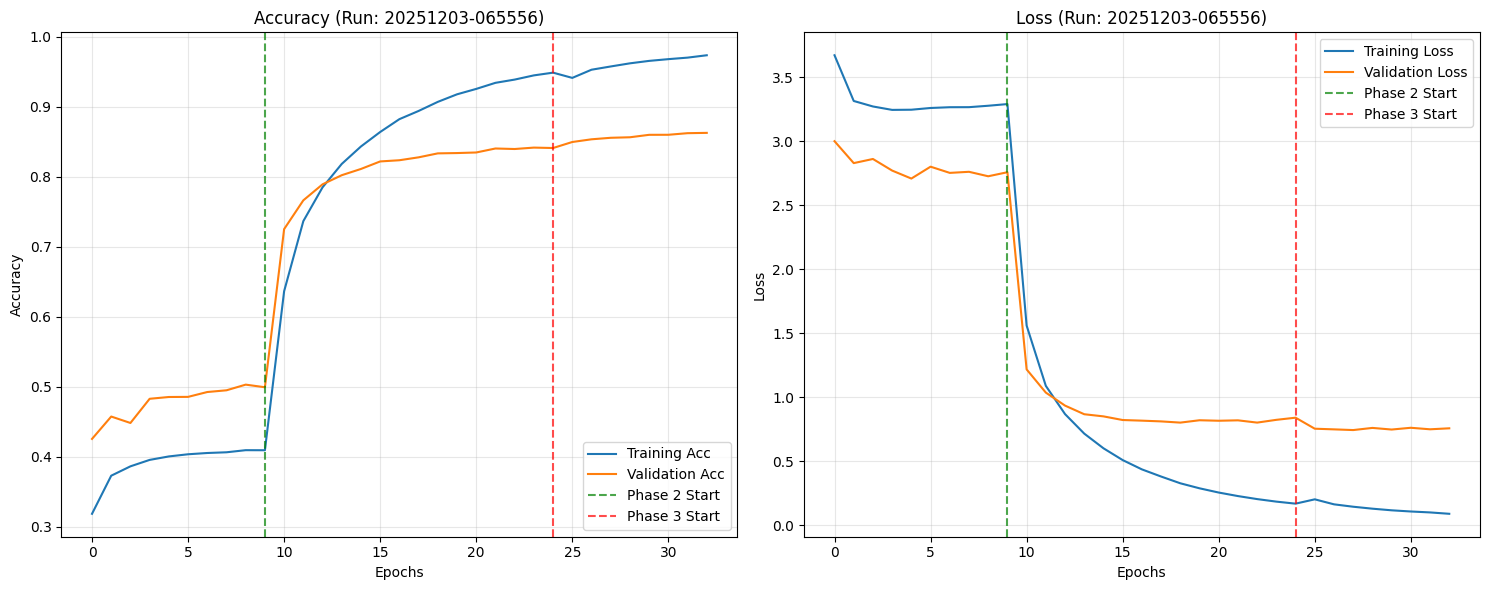


--- End of Training Session ---


In [9]:
# =============================================================================
# 📝 8. Evaluation - Save History & Plot Results (Combined 3 Phases)
# =============================================================================

import os
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Saving History & Plotting Combined Results ---")

# 1. Define Paths
hist_path_p1 = os.path.join(BASE_SAVE_PATH, f"B6_{RUN_TIMESTAMP}_History_P1.npy")
hist_path_p2 = os.path.join(BASE_SAVE_PATH, f"B6_{RUN_TIMESTAMP}_History_P2.npy")
hist_path_p3 = os.path.join(BASE_SAVE_PATH, f"B6_{RUN_TIMESTAMP}_History_P3.npy")

# 2. Helper function to get history data (Memory -> File -> Empty)
def get_and_save_history(history_obj, save_path):
    data = {}
    # Case A: Variable exists in memory (Just finished training)
    if history_obj is not None:
        data = history_obj.history
        np.save(save_path, data)
        print(f"💾 Saved history to: {save_path}")
    # Case B: Variable missing, try loading from file (Kernel restarted)
    elif os.path.exists(save_path):
        data = np.load(save_path, allow_pickle=True).item()
        print(f"📂 Loaded history from: {save_path}")
    return data

# 3. Retrieve Data safely
# (Check if variables h1, h2, h3 exist in local scope, else None)
h1_obj = locals().get('h1', None)
h2_obj = locals().get('h2', None)
h3_obj = locals().get('h3', None)

h1_data = get_and_save_history(h1_obj, hist_path_p1)
h2_data = get_and_save_history(h2_obj, hist_path_p2)
h3_data = get_and_save_history(h3_obj, hist_path_p3)

# 4. Combine Metrics
# Use 'get' with empty list fallback to prevent errors if a phase was skipped
metric_acc = 'sparse_categorical_accuracy'
metric_val_acc = 'val_sparse_categorical_accuracy'

acc = h1_data.get(metric_acc, []) + h2_data.get(metric_acc, []) + h3_data.get(metric_acc, [])
val_acc = h1_data.get(metric_val_acc, []) + h2_data.get(metric_val_acc, []) + h3_data.get(metric_val_acc, [])
loss = h1_data.get('loss', []) + h2_data.get('loss', []) + h3_data.get('loss', [])
val_loss = h1_data.get('val_loss', []) + h2_data.get('val_loss', []) + h3_data.get('val_loss', [])

# 5. Plotting
if not acc:
    print("❌ No training data found to plot.")
else:
    # Calculate phase boundaries for vertical lines
    end_p1 = len(h1_data.get('loss', [])) - 1
    end_p2 = end_p1 + len(h2_data.get('loss', []))

    plt.figure(figsize=(15, 6))

    # --- Graph 1: Accuracy ---
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    
    # Draw phase lines
    if end_p1 > 0:
        plt.axvline(x=end_p1, color='green', linestyle='--', alpha=0.7, label='Phase 2 Start')
    if len(h3_data) > 0:
        plt.axvline(x=end_p2, color='red', linestyle='--', alpha=0.7, label='Phase 3 Start')

    plt.title(f'Accuracy (Run: {RUN_TIMESTAMP})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # --- Graph 2: Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    
    # Draw phase lines
    if end_p1 > 0:
        plt.axvline(x=end_p1, color='green', linestyle='--', alpha=0.7, label='Phase 2 Start')
    if len(h3_data) > 0:
        plt.axvline(x=end_p2, color='red', linestyle='--', alpha=0.7, label='Phase 3 Start')

    plt.title(f'Loss (Run: {RUN_TIMESTAMP})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # Save Plot
    plot_path = os.path.join(BASE_SAVE_PATH, f"B6_{RUN_TIMESTAMP}_CombinedPlot.png")
    plt.tight_layout()
    plt.savefig(plot_path)
    print(f"✅ Graph saved to: {plot_path}")
    plt.show()

print("\n--- End of Training Session ---")